## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [30]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')

wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))


[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


In [31]:
wsj[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [41]:
# Splitting into train and test

train_set, test_set = train_test_split(wsj,test_size=0.05)

print(len(train_set))
print(len(test_set))


3718
196


In [42]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95734

In [43]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
# vocabulary
V = set(tokens)
print(len(V))
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12095


12

## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [44]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [45]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [46]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)


(0, 0)


In [48]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [49]:
##validating the matrix
s=0
for i in range(len(T)):
    s+=tags_matrix[5,i]
s

1.0000000018626451

In [50]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

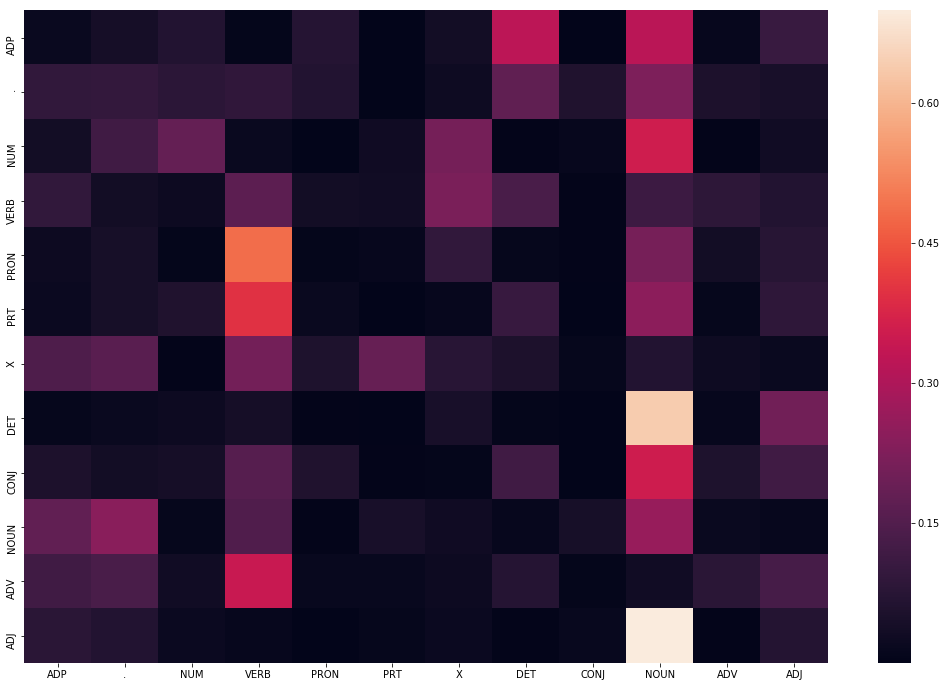

In [51]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


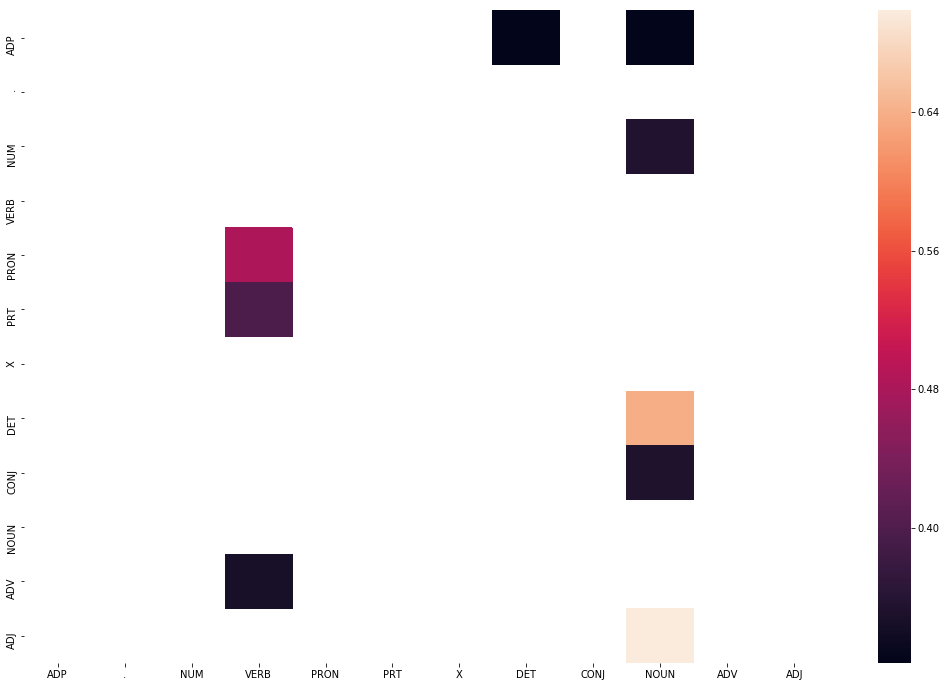

In [52]:
# frequent tags
# filter the df to get P(t2, t1) > 0.3
tags_frequent = tags_df[tags_df>0.3]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [53]:
len(train_tagged_words)

95734

In [54]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [56]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
#import random

#random.seed(1234)

# choose random 5 sents
#rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in range(len(test_set))]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run[:9]

[[('Structural', 'NOUN'),
  ('Dynamics', 'NOUN'),
  ('Research', 'NOUN'),
  ('Corp.', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-143', 'X'),
  ('makes', 'VERB'),
  ('computer-aided', 'ADJ'),
  ('engineering', 'NOUN'),
  ('software', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('introduced', 'VERB'),
  ('new', 'ADJ'),
  ('technology', 'NOUN'),
  ('in', 'ADP'),
  ('mechanical', 'ADJ'),
  ('design', 'NOUN'),
  ('automation', 'NOUN'),
  ('that', 'DET'),
  ('*T*-144', 'X'),
  ('will', 'VERB'),
  ('improve', 'VERB'),
  ('mechanical', 'ADJ'),
  ('engineering', 'NOUN'),
  ('productivity', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('Markey', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('we', 'PRON'),
  ('could', 'VERB'),
  ('have', 'VERB'),
  ('done', 'VERB'),
  ('this', 'DET'),
  ('in', 'ADP'),
  ('public', 'NOUN'),
  ("''", '.'),
  ('because', 'ADP'),
  ('so', 'ADV'),
  ('little', 'ADV'),
  ('sensitive', 'ADJ'),
  ('information', 'NOUN'),
  ('was', 'VE

In [69]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [70]:
print("Time taken in seconds: ", difference)
#print(test_run_base)

Time taken in seconds:  671.5208144187927


In [71]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.9087414002428167

In [59]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
len(incorrect_tagged_cases)

451

In [78]:
## Testing


s = """\Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite"""

words = word_tokenize(s)

tagged_seq_test= Viterbi(words)


print(tagged_seq_test)


[('\\Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.'), ('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.'), ('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.'), ('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'N

# 1st modifcation.
### nullify the effect of emmision prob for unnown words. By taking emission prob p(unknown|tag)=lambda for all tags.


In [66]:
# Viterbi Heuristic
def Viterbi_mod1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tokens = [pair[0] for pair in train_tagged_words]
    V=set(tokens)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in V: ##known word
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p =1 ##unknown word
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [73]:
# tagging the test sentences
start = time.time()
tagged_seq_mod1 = Viterbi_mod1(test_tagged_words)
end = time.time()
difference = end-start
difference

634.9676625728607

In [74]:
# accuracy
check = [i for i, j in zip(tagged_seq_mod1, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_mod1)
accuracy

0.9390934844192634

In [76]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_mod1, test_run_base)) if j[0]!=j[1]]
len(incorrect_tagged_cases)

301

In [79]:
## Testing


s = """\Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite"""

words = word_tokenize(s)

tagged_seq_test_mod1 = Viterbi_mod1(words)


print(tagged_seq_test_mod1)


[('\\Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('us